<h1 align="center">Time evolution of electrical impedance spectra of <i>Staphylococcus aureus</i> and <i>Escherichia coli</i> bacteria</h1>
<div align="center">
    <span style="font-size: 18px;">David Alejandro Miranda Mercado, Erika Viviana Godoy Alarcón, and Ely Dannier V-Niño</span>
</div>
<div align="center">Universidad Industrial de Santander, Cra 27 Cll 9, Bucaramanga, Santander, Colombia, 680002.</div>

## 1. Import Python modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams, rc
import os
from scipy import optimize

## 2. Definitions and methods

In [2]:
figs_params_file_path = 'data/paper1_Cole_Cole_params.csv'
figs = {
    'Fig4a':{
        'path': 'data/paper1_without_Lugol_Saureus.csv',
        'bacteria':'S. aureus',
        'medium':'PBS, TSB, and methyl violet (without Lugol)',
        'data': None,
        'params': None,
    },
    'Fig4b':{
        'path': 'data/paper1_without_Lugol_Ecoli.csv',
        'bacteria':'E. coli',
        'medium':'PBS, TSB, and methyl violet (without Lugol)',
        'data': None,
        'params': None,
    },
    'Fig5a':{
        'path': 'data/paper1_with_Lugol_Saureus.csv',
        'bacteria':'S. aureus',
        'medium':'PBS, TSB, methyl violet, and Lugol ',
        'data': None,
        'params': None,
    },
    'Fig5b':{
        'path':'data/paper1_with_Lugol_Ecoli.csv',
        'bacteria':'E. coli',
        'medium':'PBS, TSB, methyl violet, and Lugol ',
        'data': None,
        'params': None,
    },
}
plot_info = {
    'S. aureus': {
        'label':'(I) Staphylococcus aureus',
        'color':'#753909',
        'marker':'o',
    },
    'E. coli': {
        'label':'(II) Escherichia coli',
        'color':'#F08220',
        'marker':'s',
    },
}

In [3]:
colors = ['#F26E21', '#F08220', '#98420C', '#5F2A0A', '#60590A']
markers = ['s', 'o', '^', '*']
times_labels =['0 h', '1 h', '2 h', '3 h']
times = [0, 1, 2, 3]
dpi = 200
figsize=(6, 6)

In [4]:
def cole_cole(f, Xi, DX, tau, alpha):
    return Xi + DX / ( 1 + (2j*np.pi*f*tau)**(1-alpha) )

In [5]:
def optimize_tau(f, X, Xi, DX, tau, alpha, algorith='least_squares'):
    def err(T):
        if T < 0:
            return 100
        X1 = cole_cole(f, Xi, DX, T, alpha)
        return sum(np.abs(X1 - X)**2)/sum(np.abs(X)**2)
    opt = np.nan
    if 'least_squares' in algorith:
        opt = optimize.least_squares(err, tau, bounds=(0, np.inf))
    if 'basinhopping' in algorith:
        opt = optimize.basinhopping(err, tau, niter=1000)
    return opt.x[0]

In [6]:
def optimize_tau_Xi(f, X, Xi, DX, tau, alpha, algorith='least_squares'):
    def err(p):
        if p[0] < 0 or p[1] < 0:
            return 100
        X1 = cole_cole(f, p[0], DX, p[1], alpha)
        return sum(np.abs(X1 - X)**2)/sum(np.abs(X)**2)
    opt = np.nan
    if 'least_squares' in algorith:
        opt = optimize.least_squares(err, [Xi, tau], bounds=(0, np.inf))
    if 'basinhopping' in algorith:
        opt = optimize.basinhopping(err, [Xi, tau], niter=1000)
    return opt.x

In [7]:
def optimize_xi(f, X, Xi0, DX0, tau0, alpha0, algorith='least_squares'):
    def err(Xi):
        if Xi < 0:
            return 100
        X1 = cole_cole(f, Xi, DX0[0], tau0[0], alpha0[0]) + cole_cole(f, 0, DX0[1], tau0[1], alpha0[1])
        return sum(np.abs(X1 - X)**2)/sum(np.abs(X)**2)
    opt = np.nan
    if 'least_squares' in algorith:
        opt = optimize.least_squares(err, Xi0, bounds=(0, np.inf))
    if 'basinhopping' in algorith:
        opt = optimize.basinhopping(err, Xi0, niter=1000)
    return opt.x[0]

In [8]:
def get_cole_params(f, X, algorith='least_squares', verbose=True):
    def f_2b(c):
        """ calculate the algebraic distance between the 2D points and the mean circle centered at c=(-xc, -yc, C) """
        A, B, C = c
        Xi = 100
        if A**2 >= C: 
            R = np.sqrt(A**2 + B**2 - C)
            Xi = A + np.sqrt( A**2 - C )
        x = np.real(X)
        y = np.imag(X)
        r = x**2 + y**2 + 2*x*A + 2*y*B + C
        if Xi < 0:
            return 10*r
        return r
    x_m = np.mean(np.real(X))
    R0  = ( max(np.real(X)) - min(np.real(X)) )/2.0
    y_m = max(np.imag(X)) - R0
    C0  =  x_m**2 + y_m**2 - R0**2
    ABC = -x_m, -y_m, C0
    ABC_opt, ier = optimize.leastsq(f_2b, ABC)
    A, B, C = ABC_opt
    R = np.sqrt(A**2 + B**2 - C) # (y + B)^2 + (x + A)^2 = R^2
    if R**2 < B**2:
        if verbose:
            print('Warning! The Cole-Cole inversion fails.')
        return np.nan, np.nan, np.nan, np.nan
    DX = 2 * np.sqrt( R**2 - B**2 )
    Xi1 = -A - DX/2
    Xi2 =  A + DX/2
    Xmax = R - B
    phi = np.arctan(-2*B/DX)
    alpha = 2 * phi / np.pi

    def get_tau(Xi):
        # Obtention of tau #
        k = min(range(len(f)), key=lambda i: abs(-np.imag(X)[i] - Xmax))
        fc = f[k]
        if type(fc) == type([]):
            fc = fc[0]
        if DX/(DX+Xi) < 0:
            return 1
        return np.sqrt(DX/(DX+Xi))/(2*np.pi*fc)

    X1 = cole_cole(f, Xi1, DX, get_tau(Xi1), alpha)
    X2 = cole_cole(f, Xi2, DX, get_tau(Xi2), alpha)
    Xi = Xi1
    tau = get_tau(Xi1)
    if sum(np.abs(X1 - X)**2) > sum(np.abs(X2 - X)**2):
        Xi = Xi2
        tau = get_tau(Xi2)
    
    tau_opt = optimize_tau(f, X, Xi, DX, tau, alpha, algorith=algorith)
    X1 = cole_cole(f, Xi1, DX, tau, alpha)
    X2 = cole_cole(f, Xi2, DX, tau_opt, alpha)
    if not np.isnan(tau_opt) and sum(np.abs(X1 - X)**2) > sum(np.abs(X2 - X)**2):
        tau = tau_opt

    return Xi, DX, tau, alpha 

In [9]:
def get_params(params, time, f, R, I, fmin=30, optimize_tau=False):
    if params is None:
        k = f > fmin
        Ri, DR, tau, alpha = get_cole_params(f[k], R[k] - 1j*I[k])
        return Ri, DR, tau, alpha
    if isinstance(params, pd.DataFrame):
        pdf = params.loc[params['Hours'] == time]
        Ri = pdf['Ri'].values[0]
        DR = pdf['DR'].values[0]
        tau = pdf['tau'].values[0]
        alpha = pdf['alpha'].values[0]
        if optimize_tau:
            tau = optimize_tau(f, R-1j*I, Ri, DR, tau, alpha)
        #Ri, tau, optimize_tau_Xi(f, R-1j*I, Ri, DR, tau, alpha)
        return Ri, DR, tau, alpha

In [10]:
def Z_abs_and_nyquists(data, params=None, show_bode=False, colors=colors, markers=markers, time_labels=times_labels, dpi=dpi, figsize=figsize, optimize_tau=False):
    f = data[('Frequency', 'Hz')]
    ic = -1; im = -1
    fig1 = None
    if show_bode:
        fig1 = plt.figure(dpi=dpi, figsize=figsize)
        fig1 = fig1.number if not isinstance(fig1, int) else fig1
    fig2 = plt.figure(dpi=dpi, figsize=figsize)
    fig2 = fig2.number if not isinstance(fig2, int) else fig2
    xmax = 0
    for tl in time_labels:
        ic = ic+1 if ic < len(colors)-1 else 0
        im = im+1 if im < len(colors)-1 else 0
        bacteria =''
        medium   = ''
        if isinstance(params, pd.DataFrame):
            bacteria = params.loc[params['Hours'] == tl]['Bacteria'].values[0]
            medium = params.loc[params['Hours'] == tl]['Medium'].values[0]
        Z = data[('|Z|', tl)]
        x = data[("Z'", tl)]
        y = data[("Z''", tl)]
        Ri, DR, tau, alpha = get_params(params, tl, f, x, y, optimize_tau=optimize_tau)
        ffit = np.logspace(-2, 6, 1000)
        Zfit = cole_cole(ffit, Ri, DR, tau, alpha)
        xmax = max(Zfit.real) if max(Zfit.real) > xmax else xmax
        label = fr'{tl}: $R_1={Ri:.1f}\Omega$, $R_2={DR:.1f}\Omega$, $\tau={1e3*tau:.2f}ms$, $\alpha={alpha:.3f}$'
        title = f'{bacteria} in {medium}'
        if show_bode:
            plt.figure(fig1)
            plt.semilogx(f, Z, color=colors[ic], marker=markers[im], linestyle='None', label=tl)
            plt.semilogx(ffit, np.abs(Zfit), color=colors[ic])
            plt.title(title)
        plt.figure(fig2)
        plt.plot(x, y, color=colors[ic], marker=markers[im], linestyle='None', label=label)
        plt.plot(Zfit.real, -Zfit.imag, color=colors[ic])
        plt.title(title)
    
    if show_bode:
        plt.figure(fig1)
        plt.legend()
        plt.xlim(5, 5e5)
        plt.xlabel('Frequency (Hz)')
        plt.ylabel(r'$|Z|$  $(\Omega)$')
    
    plt.figure(fig2)
    plt.legend()
    plt.axis('square')
    plt.xlim(0, 1.1*xmax)
    plt.ylim(0, 1.1*xmax)
    plt.xlabel(r'$Z\rq$  $(\Omega)$')
    plt.ylabel(r'$Z\rq\rq$  $(\Omega)$')
    
    plt.show()

In [11]:
def linear_fit(row, times=times):
    coefficients = np.polyfit(times, row, 1)
    return coefficients

In [12]:
def quadratic_fit(row, times=times):
    coefficients = np.polyfit(times, row, 2)
    return coefficients

In [13]:
def set_figs(figs, cronoimpedance_column='|Z|'):
    for k in figs.keys():
        path = figs[k]['path']
        data = pd.read_csv(path, sep=';', header=[0, 1])
        df_linear = data[cronoimpedance_column].apply(linear_fit, axis=1, result_type='expand')
        df_quadratic = data[cronoimpedance_column].apply(quadratic_fit, axis=1, result_type='expand')
        data[(cronoimpedance_column, 'slope')] = df_linear[0]
        data[(cronoimpedance_column, 'intercept')] = df_linear[1]
        data[(cronoimpedance_column, 'a2')] = df_quadratic[0]
        data[(cronoimpedance_column, 'a1')] = df_quadratic[1]
        data[(cronoimpedance_column, 'a0')] = df_quadratic[2]
        data[(cronoimpedance_column, 'x0')] = -df_quadratic[1]/(2*df_quadratic[0])
        figs[k]['data'] = data

In [14]:
def plot_cronoimpedance(data, label='', cronoimpedance_column='|Z|', param='slope',color='k', linestyle='None', marker='s', fontsize = 12):
    f = data[('Frequency', 'Hz')].to_numpy()
    m = data[cronoimpedance_column][param].to_numpy()
    plt.semilogx(f, m, color=color, marker=marker, linestyle=linestyle, label=label)
    plt.xlabel(r'$\bf{Frequency\,(Hz)}$', fontsize=fontsize)
    plt.ylabel(rf'$\bf{{d{cronoimpedance_column}/dt}}$  $\bf{{(\Omega/h)}}$', fontsize=fontsize)
    plt.gca().set_box_aspect(1)
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)

In [15]:
def set_cronoimpedance(data, time_labels=times_labels, times=times):
    f = data[('Frequency', 'Hz')]
    ic = -1; im = -1
    data['|Z|'][time_labels]
    data['|Z|'][['slope', 'intercept']] = data['|Z|'].apply(linear_fit, axis=1, result_type='expand')
    for tl in times_labels:
        ic = ic+1 if ic < len(colors)-1 else 0
        im = im+1 if im < len(colors)-1 else 0
        bacteria =''
        medium   = ''
        Z = data[('|Z|', tl)]
        x = data[("Z'", tl)]
        y = data[("Z''", tl)]

In [16]:
def plot_figures(figs, params_all=None, show_bode=False, optimize_tau=False):
    for k in figs.keys():
        data = figs[k]['data']
        print(k)
        params = None
        if isinstance(params_all, pd.DataFrame):
            params = params_all.loc[params_all['Fig']==k]
        Z_abs_and_nyquists(data, params=params, show_bode=show_bode, optimize_tau=optimize_tau)

## 3. Figures

In [17]:
set_figs(figs)
params_all = pd.read_csv(figs_params_file_path, sep=';')

Fig4a


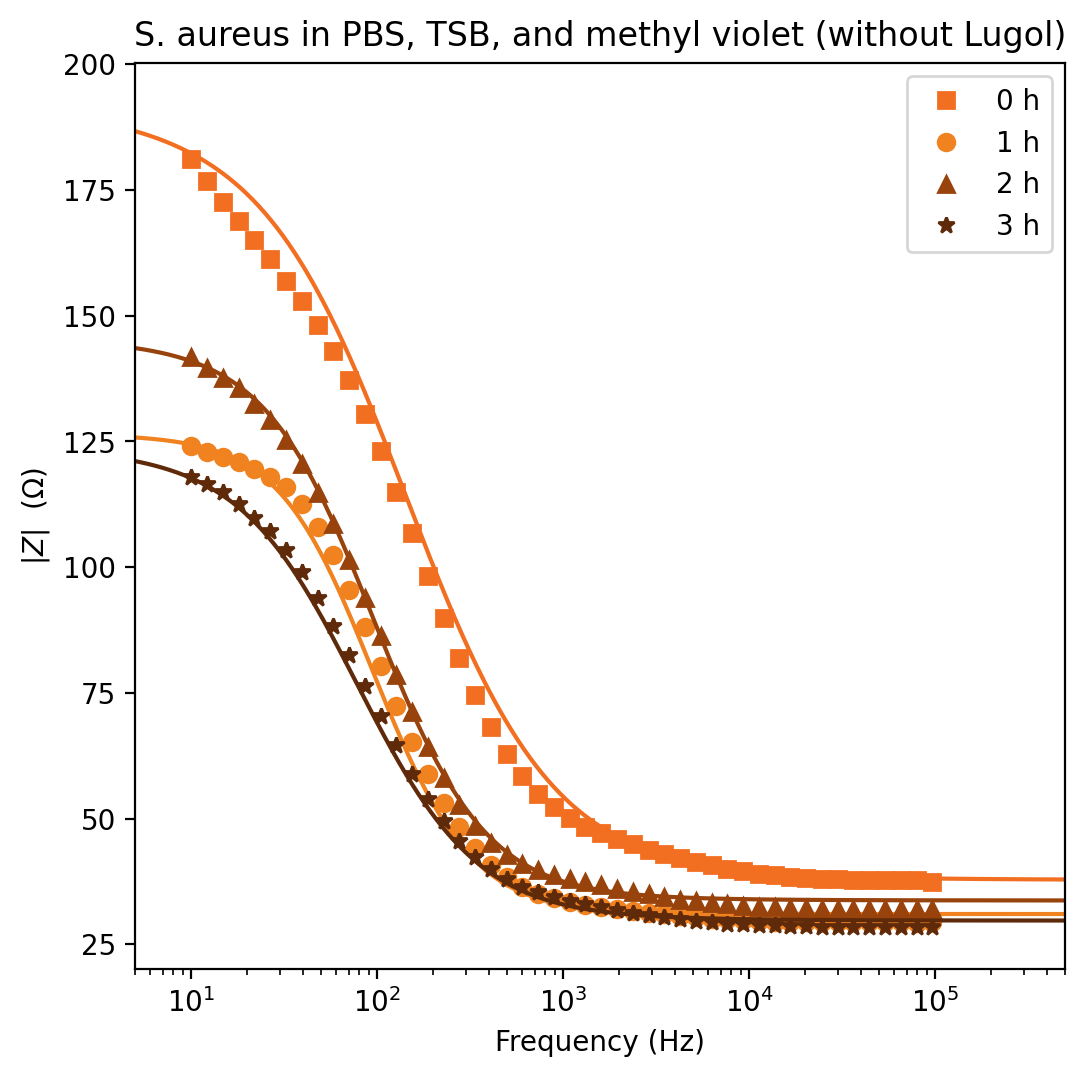

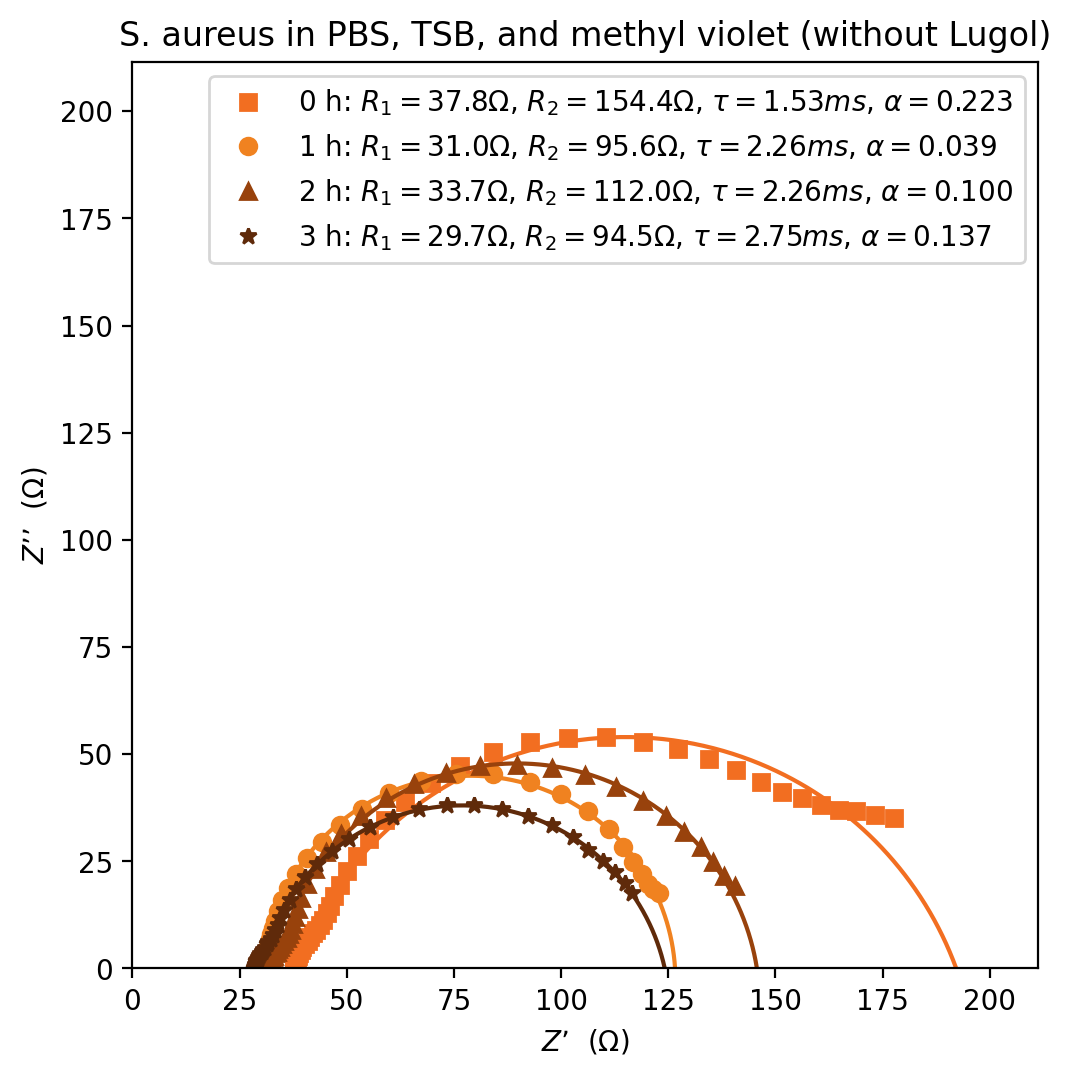

Fig4b


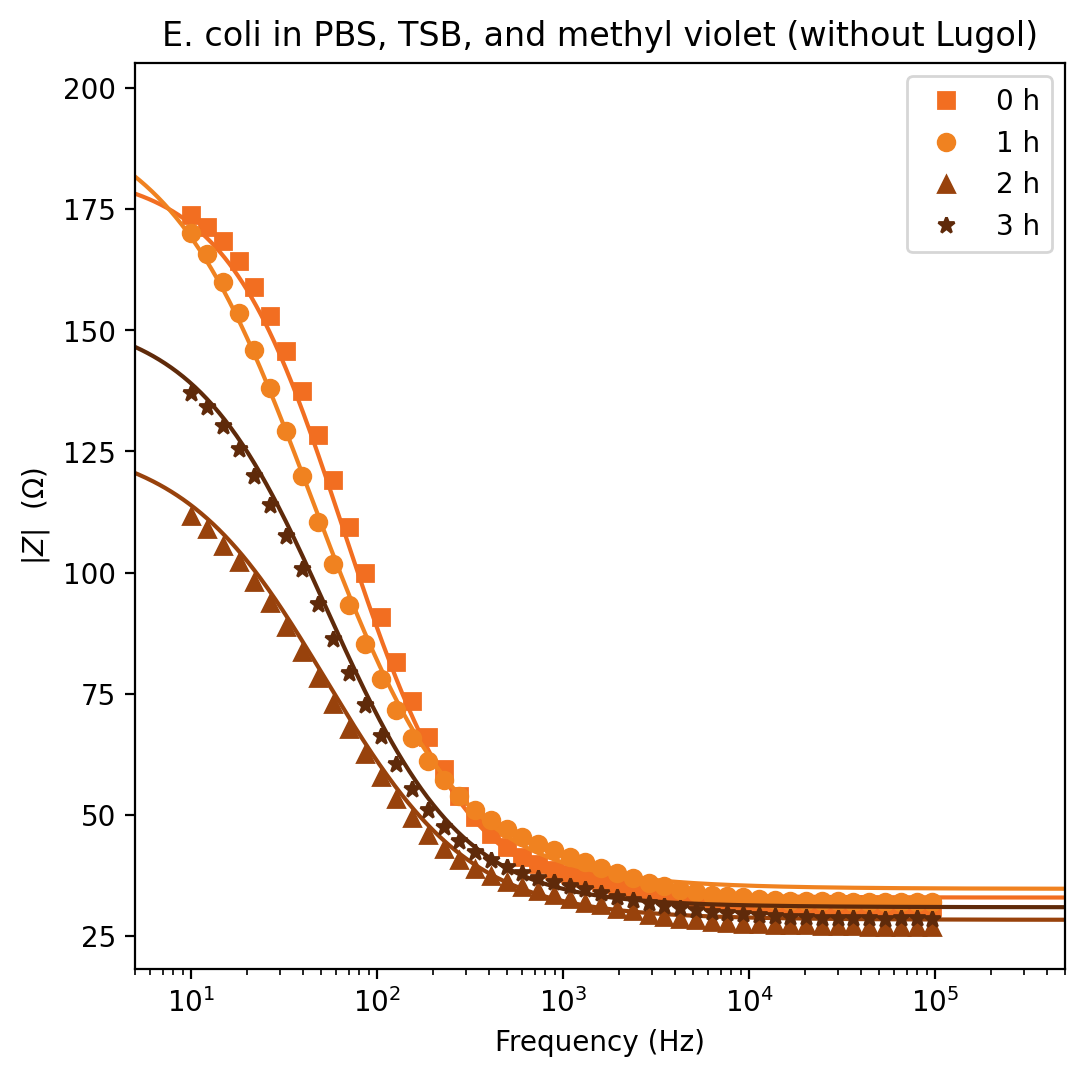

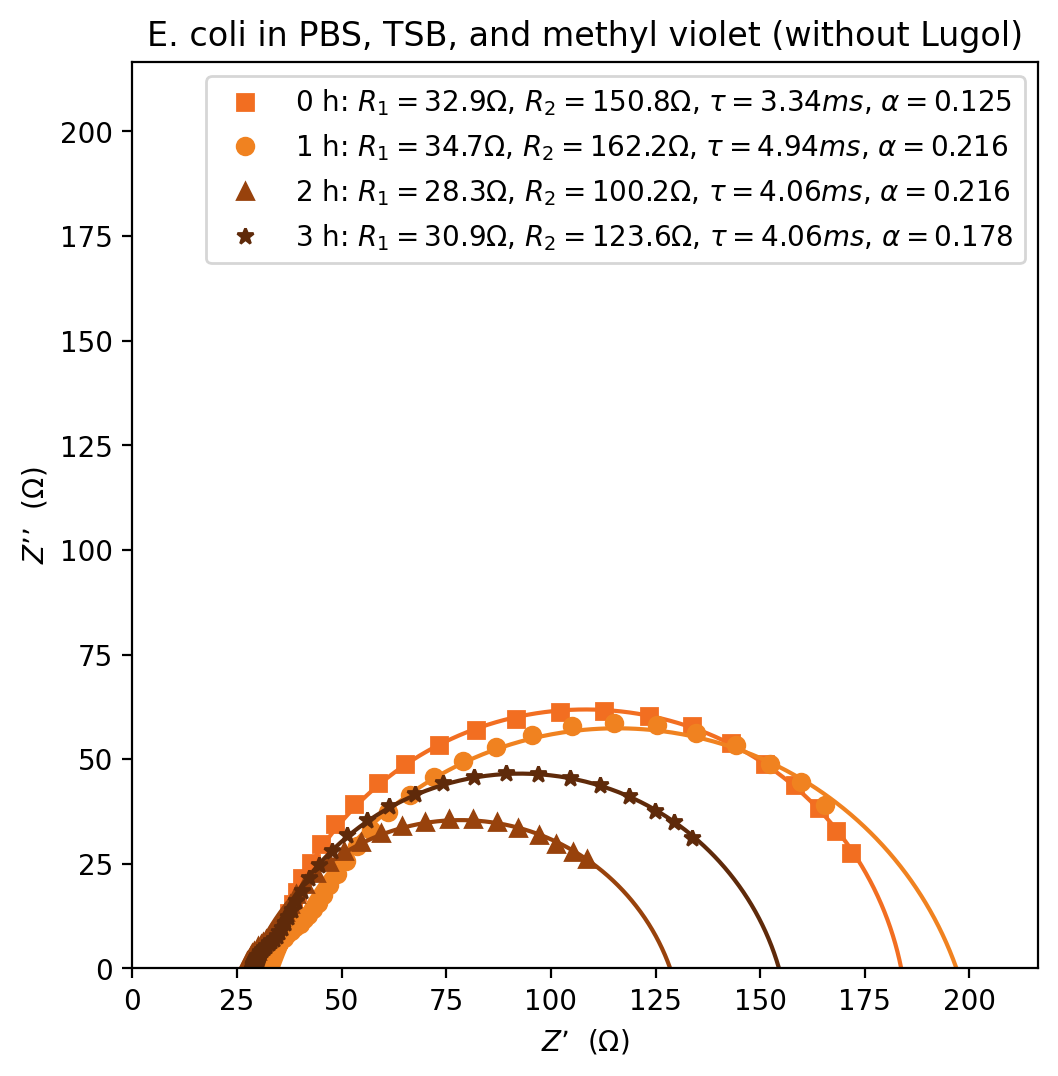

Fig5a


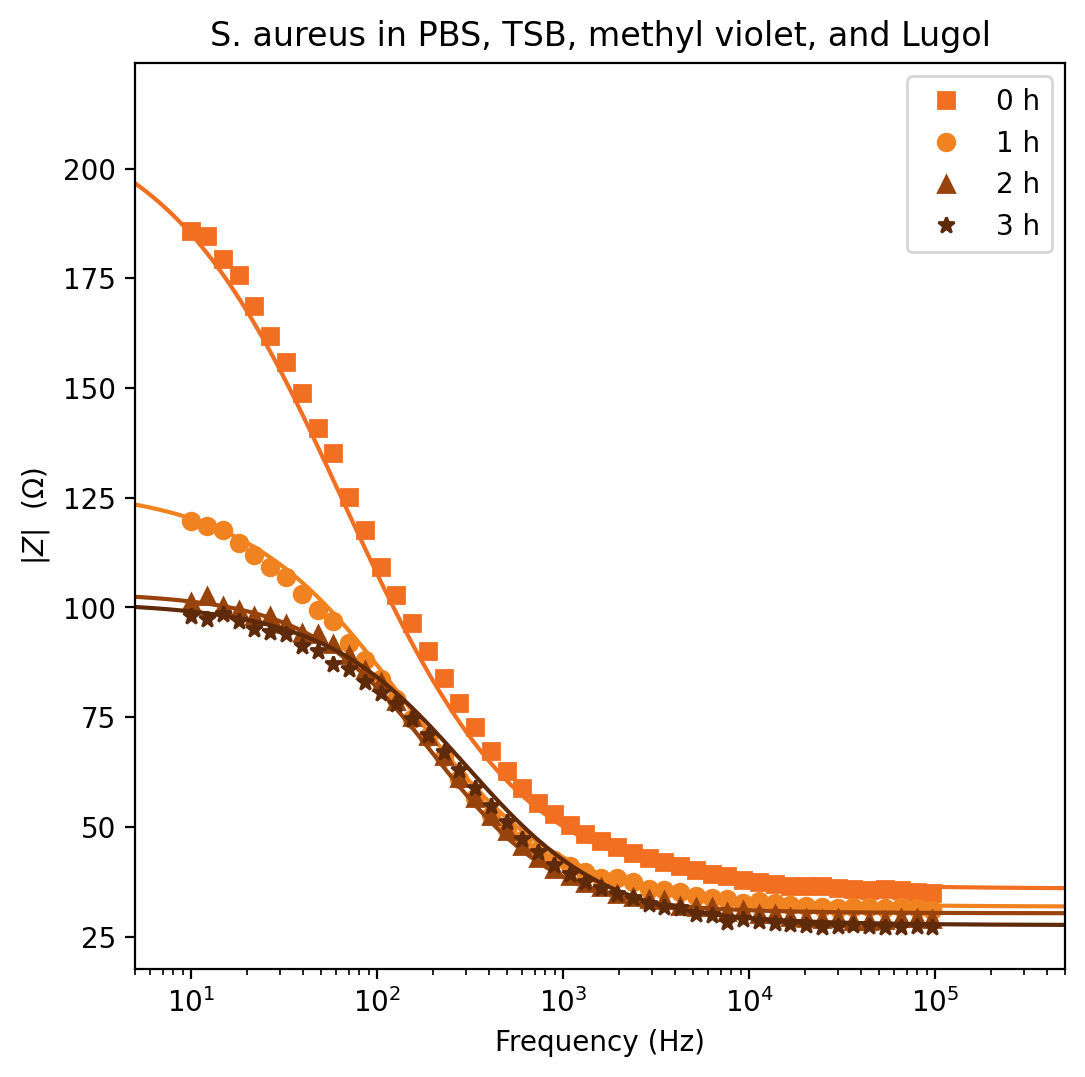

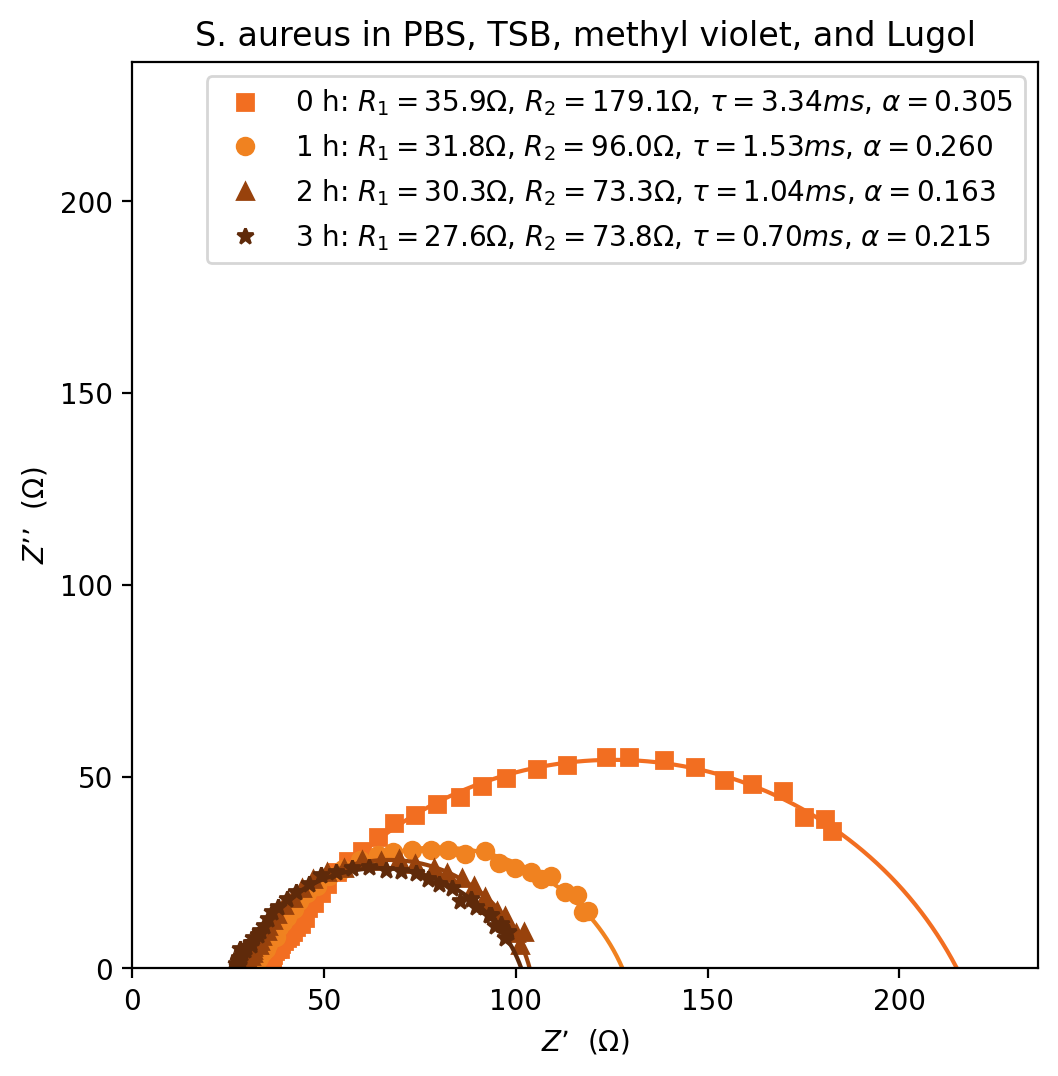

Fig5b


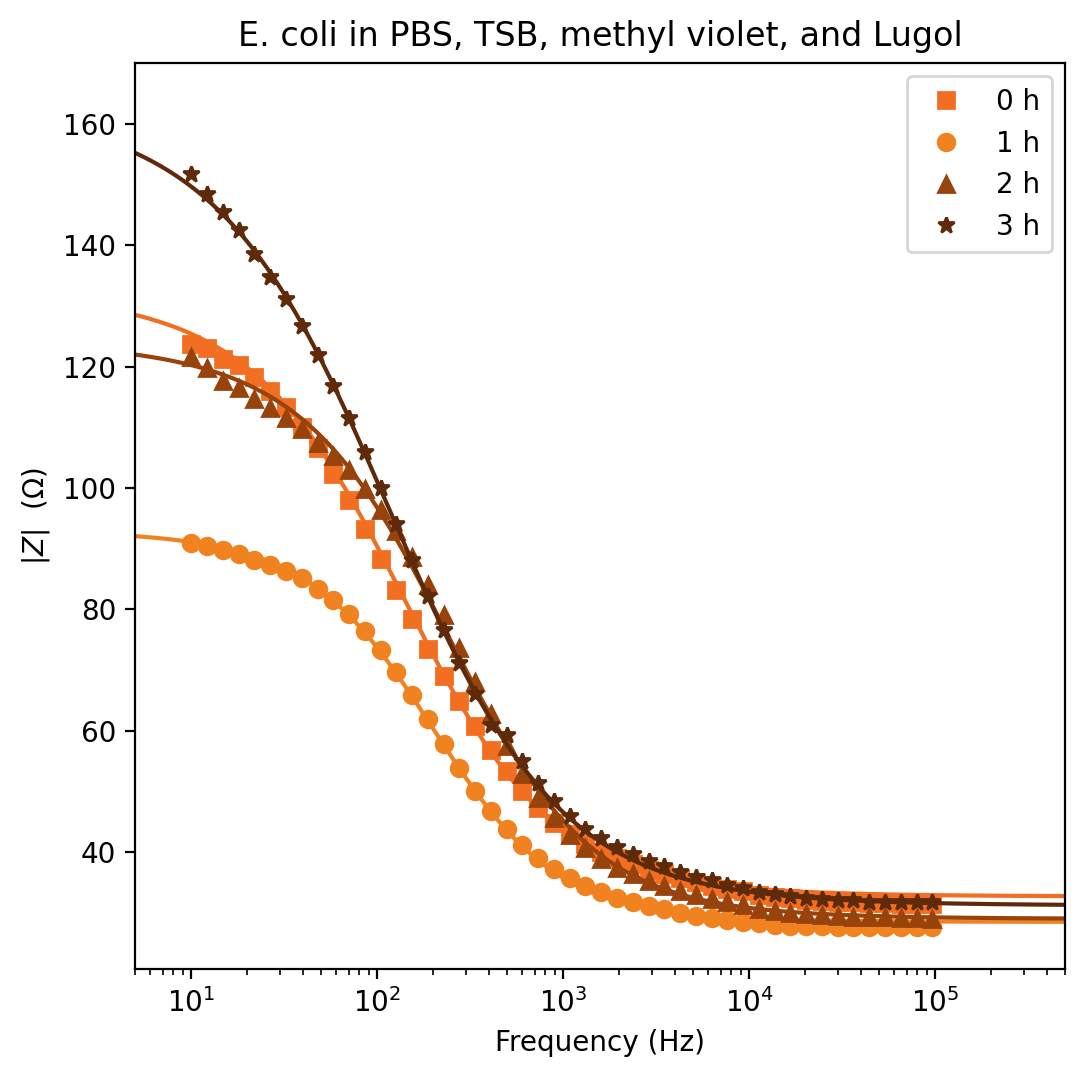

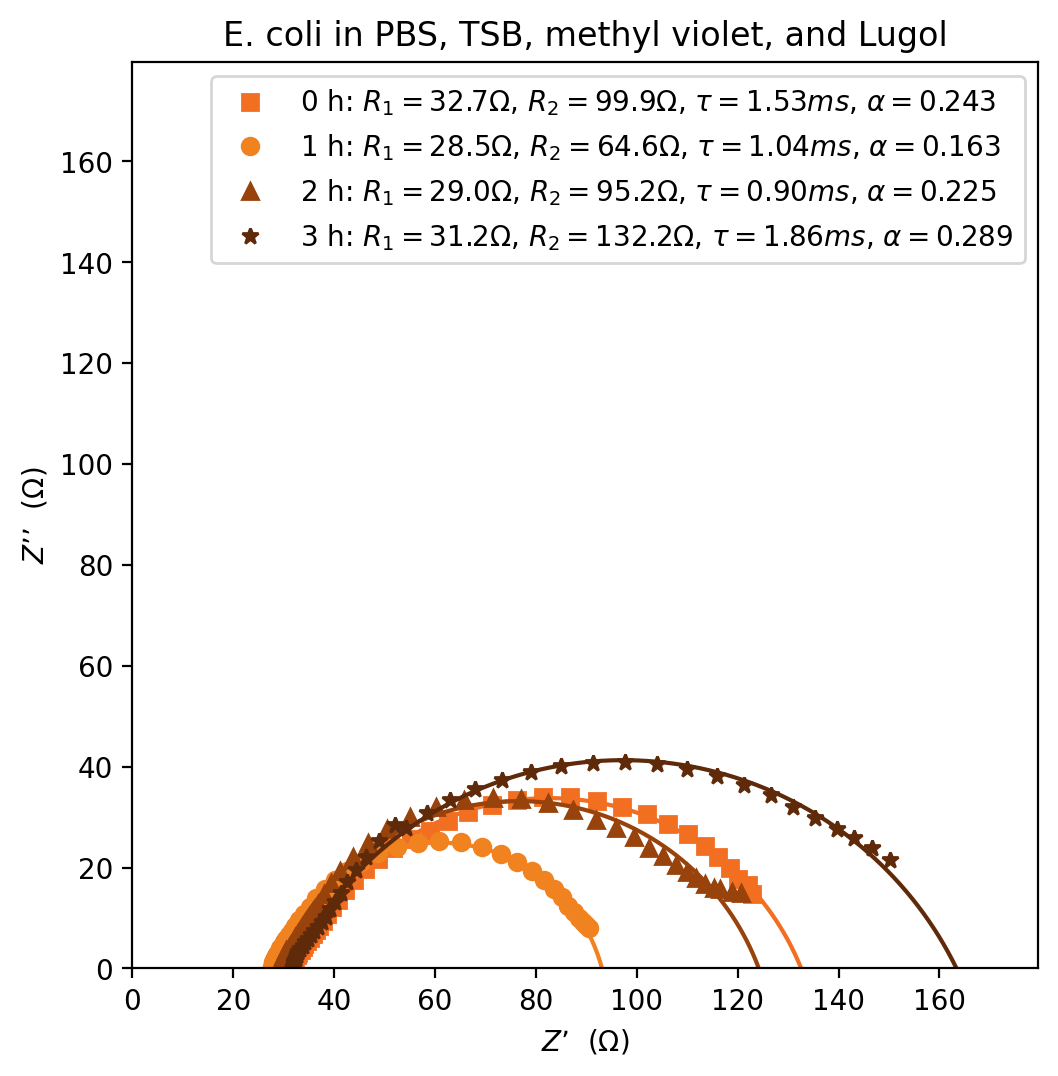

In [18]:
plot_figures(figs, params_all=params_all, show_bode=True, optimize_tau=False)

PBS, TSB, and methyl violet (without Lugol)
PBS, TSB, and methyl violet (without Lugol)


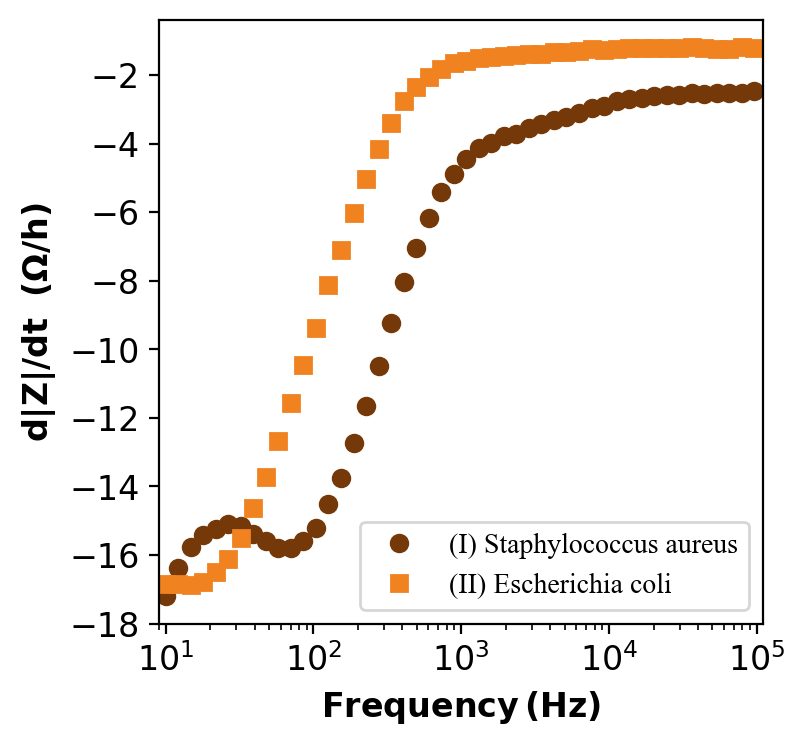

In [19]:
plt.figure(dpi=dpi)
param='slope'
for fig in ['Fig4a', 'Fig4b']:
    print(figs[fig]['medium'])
    bacteria=figs[fig]['bacteria']
    label=plot_info[bacteria]['label']
    color=plot_info[bacteria]['color']
    marker=plot_info[bacteria]['marker']
    plot_cronoimpedance(figs[fig]['data'], label=label, color=color, marker=marker, param=param)
_ = plt.legend(loc=4, prop={'family':'Times New Roman'})
_ = plt.xlim(0.9e1, 1.1e5)

PBS, TSB, methyl violet, and Lugol 
PBS, TSB, methyl violet, and Lugol 


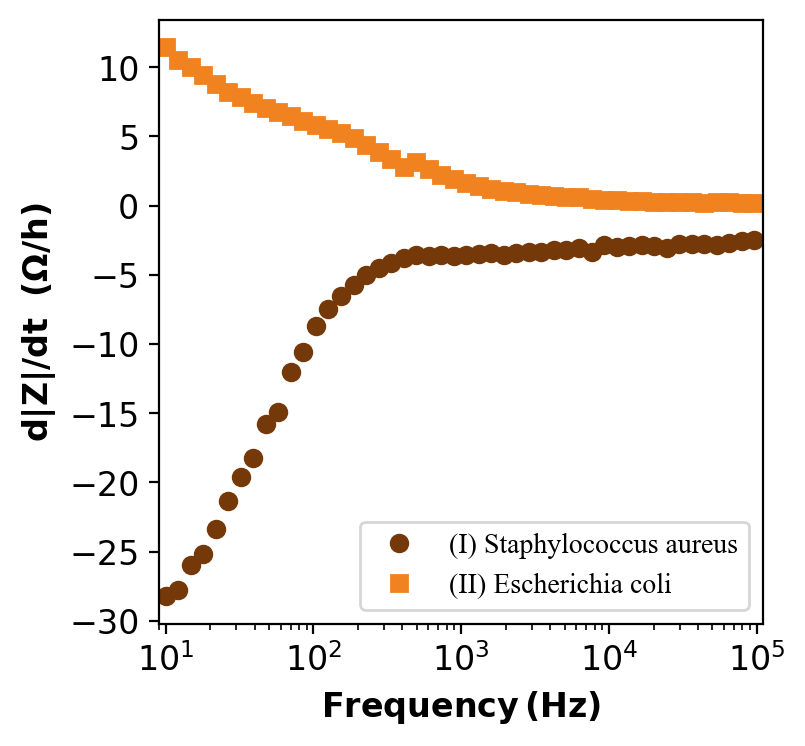

In [20]:
plt.figure(dpi=dpi)
param='slope'
for fig in ['Fig5a', 'Fig5b']:
    print(figs[fig]['medium'])
    bacteria=figs[fig]['bacteria']
    label=plot_info[bacteria]['label']
    color=plot_info[bacteria]['color']
    marker=plot_info[bacteria]['marker']
    plot_cronoimpedance(figs[fig]['data'], label=label, marker=marker, color=color, param=param)
_ = plt.legend(loc=4, prop={'family':'Times New Roman'})
_ = plt.xlim(0.9e1, 1.1e5)

End!